## Uncertainty reduction in homogenization problems

#### Background
Homogenization or scale bridging is a well-established strategy in micro and multiscale mechanics in order to understand the origin of a property at different length scales. The starting point in this type of problems is to build a virtual or real microstructural volume element that is statistically representative. The proper size of such a representative volume (RVE) is unknows at the beginning, and usually it is determined by the convergence test of the property. If the property of interest is nonlinear or multiphysics related then the size is expected to be very large. Since the actual size of an RVE for a specific case is unknown, most researchers assume a rough size to be a proper sized RVE. For example, if the material is a complex polycrystalline then the reprentative size might be from hundred to few hundred $\mu m$ in one side. More specifically, if the length in one side is $d$ then the proper size would be $d\times d\times d \mu m^3$, considering a cubic RVE.

It is to be noted that a simulated property is highly RVE size dependent, meaning the results have high uncertainty. Depending on the improper size and the number of realization, the computed property might have high bias, variance or both. Lets say d is the proper size w.r.t. a specific property, where $d_1<d_2<d_3<d_4<d_5 ..... <d$. For any size less than d, there will be always some degrees of bias or variance or both. 

#### Problem description
In this notebook, an example of thermoelasticity has been presented, where homogeneized stress w.r.t. the proper RVE has been predicted with recurrent network. Five datasets of homogenized thermoelastic stress have been generated with lower sized VE. Training these five sets as a series with LSTM network, few next datasets have been predicted until a clear convergence is visible with negligble variance. By doing so, highly accurate homogenized properties can be computed with very less computations. Morevoer, the proper RVE size can also be assessed. 

#### Mechanics probelm, boundary conditions etc.
The TiAl alloy family is an important class of materials for high temperature aerospace application, like turbine blade etc. Among a number of varieties, the duplex type is especially attractive for aero-engines. This duplex has two types of grains, i.e. lamellar and globular type. Both thermal and mechanical loading have been applied to a duplex TiAl polycrystalline alloys, and afterwards, developed stressese (homogenized) have been computed for 5 different size of microstructural VE. At the top surface of VEs, a fixed temperature ($800^\circ C$) has been applied for 200 seconds. All other surfaces are exposed to room temperature. After 100 seconds, a constant displance rate has been applied from top surface so that the total displacement becomes 1%. The middle point of the bottom surface was fixed and the whole bottom surface was contrained ($U_z = 0$).  Assumung the thermo-elastic material model, stresses at each nodal points are computed. Then volumetric average of the most dominat component ($\sigma_{33}$) has been computed at each time step. So there are 200 values for each dataset. However, we do not need to use all the datapoints in a dataset. A few would be sufficient to represent the overall behavior. For example, if we take ($\sigma_{33}$) at every 10th second, i.e. 10, 20, ....200 etc., that would be representiative (Please see the curves below for training datasets).

#### Input and output of the LSTM network
Homogenized stresses for a particualr size is a compoent of the series. So we will have a sequence of 5 components, each of them will have 200 values, however, we will reduce these 200 into 20. At the end, a componet of the sequence will have 20 values.  

#### Importing necessary modules

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


#### Loading the training datasets

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Saving RVEsize-Homogenization1.txt to RVEsize-Homogenization1.txt


#### Reading and visualizing the series

In [ ]:

dataset= np.loadtxt(io.BytesIO(uploaded['RVEsize-Homogenization1.txt'])) 

RVEsize =  dataset[0]
series= dataset[1:]
series = np.transpose(series)
series

array([[-3.85728372e+01, -5.49696605e+01, -6.75108209e+01,
        -7.80635725e+01, -8.73350760e+01, -9.56729234e+01,
        -1.03271046e+02, -1.10247634e+02, -1.16681362e+02,
        -1.22629082e+02, -9.01058811e+01, -5.71779755e+01,
        -2.38770753e+01,  9.76832072e+00,  4.37326010e+01,
         7.79922094e+01,  1.12525554e+02,  1.47312661e+02,
         1.82335075e+02,  2.17575669e+02],
       [-3.01645182e+01, -4.24959971e+01, -5.17744379e+01,
        -5.94965060e+01, -6.62278128e+01, -7.22595870e+01,
        -7.77656075e+01, -8.28585971e+01, -8.76157425e+01,
        -9.20917255e+01, -5.82982513e+01, -2.42931169e+01,
         9.90116280e+00,  4.42671268e+01,  7.87909101e+01,
         1.13461358e+02,  1.48269068e+02,  1.83206352e+02,
         2.18266220e+02,  2.53442698e+02],
       [-2.29372278e+01, -3.22702133e+01, -3.92435865e+01,
        -4.50476037e+01, -5.01266838e+01, -5.47012760e+01,
        -5.88988089e+01, -6.28006302e+01, -6.64623979e+01,
        -6.99241136e+01, -3.5

#### Five datasets of the series in a figure

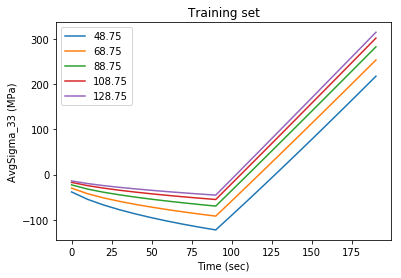

In [ ]:
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training set')
plt.legend()

plt.show()

#### At first try with DNN, and observe whether DNN can predict next sequences. Finding the best learning rate is not attempted here, as it is already known from other similar problems that 2.5e-2 works the best here.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.1) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    keras.layers.Dense(units=1024, activation='relu', input_shape=[1]),
    keras.layers.Dense(units=2048,activation='relu'),
    keras.layers.Dense(units=512,activation='relu'),
    keras.layers.Dense(units=20)
])

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
Huber=loss=tf.keras.losses.Huber()
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(RVEsize, series, epochs=1000, callbacks=[callbacks]) 

Train on 5 samples
Epoch 1/1000
5/5 [==============================] - 0s 88ms/sample - loss: 14341.0410
Epoch 2/1000
5/5 [==============================] - 0s 1ms/sample - loss: 6482696.0000
Epoch 3/1000
5/5 [==============================] - 0s 1ms/sample - loss: 80697.3203
Epoch 4/1000
5/5 [==============================] - 0s 1ms/sample - loss: 10905.3076
Epoch 5/1000
5/5 [==============================] - 0s 1ms/sample - loss: 9116.3574
Epoch 6/1000
5/5 [==============================] - 0s 1ms/sample - loss: 4655.4712
Epoch 7/1000
5/5 [==============================] - 0s 1ms/sample - loss: 3064.5996
Epoch 8/1000
5/5 [==============================] - 0s 1ms/sample - loss: 2094.2791
Epoch 9/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1524.0289
Epoch 10/1000
5/5 [==============================] - 0s 1ms/sample - loss: 1444.6879
Epoch 11/1000
5/5 [==============================] - 0s 1ms/sample - loss: 1785.2273
Epoch 12/1000
5/5 [=============================

In [ ]:
print(model.predict([140.0]))
print(model.predict([150.0]))
print(model.predict([160.0]))

[[-13.213972  -18.975239  -23.008142  -26.927643  -30.260183  -33.184574
  -35.91248   -38.62457   -41.049706  -43.221436   -7.3095164  28.583271
   65.87679   102.13763   138.61726   175.22957   212.32393   249.06761
  285.9109    322.87106  ]]
[[-12.684552 -18.389622 -22.151361 -26.058586 -29.347149 -32.143974
  -34.79413  -37.509895 -39.840233 -41.923008  -5.477458  30.667791
   69.25313  106.17362  143.3465   180.68333  218.73271  256.15073
  293.76096  331.48495 ]]
[[-12.42932   -18.148506  -21.742844  -25.667366  -28.960049  -31.674898
  -34.296803  -37.04318   -39.31963   -41.34474    -4.1655307  32.54255
   72.52087   110.29311   148.35567   186.60776   225.76114   264.06046
  302.62143   341.299    ]]


#### Let's visualize the predicted three sequences

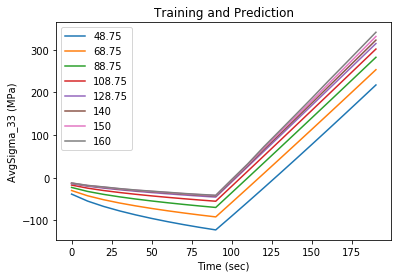

In [ ]:
time=range(0,200,10)

plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, model.predict([140.0])[0],  label='140')
plt.plot(time, model.predict([150.0])[0],  label='150')
plt.plot(time, model.predict([160.0])[0], label='160')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training and Prediction')
plt.legend()

plt.show()

#### From the predicted sequences and from the above graph, it is clear thant DNN cannot predict well outside the training set. So start with LSTM, primarily with two layers. Both X and Y will have a component of the sequence, so it will be 1-by-1 LSTM architecture.

In [ ]:
Xtrain = series[0:4]
Ytrain = series[1:5]
Xtrain

array([[-3.85728372e+01, -5.49696605e+01, -6.75108209e+01,
        -7.80635725e+01, -8.73350760e+01, -9.56729234e+01,
        -1.03271046e+02, -1.10247634e+02, -1.16681362e+02,
        -1.22629082e+02, -9.01058811e+01, -5.71779755e+01,
        -2.38770753e+01,  9.76832072e+00,  4.37326010e+01,
         7.79922094e+01,  1.12525554e+02,  1.47312661e+02,
         1.82335075e+02,  2.17575669e+02],
       [-3.01645182e+01, -4.24959971e+01, -5.17744379e+01,
        -5.94965060e+01, -6.62278128e+01, -7.22595870e+01,
        -7.77656075e+01, -8.28585971e+01, -8.76157425e+01,
        -9.20917255e+01, -5.82982513e+01, -2.42931169e+01,
         9.90116280e+00,  4.42671268e+01,  7.87909101e+01,
         1.13461358e+02,  1.48269068e+02,  1.83206352e+02,
         2.18266220e+02,  2.53442698e+02],
       [-2.29372278e+01, -3.22702133e+01, -3.92435865e+01,
        -4.50476037e+01, -5.01266838e+01, -5.47012760e+01,
        -5.88988089e+01, -6.28006302e+01, -6.64623979e+01,
        -6.99241136e+01, -3.5

In [ ]:
print(Ytrain)

[[-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
  -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
  -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
   9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
   1.48269068e+02  1.83206352e+02  2.18266220e+02  2.53442698e+02]
 [-2.29372278e+01 -3.22702133e+01 -3.92435865e+01 -4.50476037e+01
  -5.01266838e+01 -5.47012760e+01 -5.88988089e+01 -6.28006302e+01
  -6.64623979e+01 -6.99241136e+01 -3.51816207e+01 -2.91889294e-01
   3.47271115e+01  6.98609524e+01  1.05098072e+02  1.40428913e+02
   1.75845570e+02  2.11341529e+02  2.46911186e+02  2.82549922e+02]
 [-1.73896568e+01 -2.46148317e+01 -3.01721320e+01 -3.48687743e+01
  -3.90131096e+01 -4.27635134e+01 -4.62146386e+01 -4.94285627e+01
  -5.24485758e+01 -5.53062450e+01 -1.99937367e+01  1.54387787e+01
   5.09765871e+01  8.66077783e+01  1.22322597e+02  1.58112883e+02
   1.93971778e+02  2.29893405e+02  2.65872707e+02  3.01905458e+02]
 [-1.41

#### Transforming input data from 2D to 3D tensor, it is necessary for LSTM.

In [ ]:
Xtrain=Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1], 1))
Xtrain

array([[[-3.85728372e+01],
        [-5.49696605e+01],
        [-6.75108209e+01],
        [-7.80635725e+01],
        [-8.73350760e+01],
        [-9.56729234e+01],
        [-1.03271046e+02],
        [-1.10247634e+02],
        [-1.16681362e+02],
        [-1.22629082e+02],
        [-9.01058811e+01],
        [-5.71779755e+01],
        [-2.38770753e+01],
        [ 9.76832072e+00],
        [ 4.37326010e+01],
        [ 7.79922094e+01],
        [ 1.12525554e+02],
        [ 1.47312661e+02],
        [ 1.82335075e+02],
        [ 2.17575669e+02]],

       [[-3.01645182e+01],
        [-4.24959971e+01],
        [-5.17744379e+01],
        [-5.94965060e+01],
        [-6.62278128e+01],
        [-7.22595870e+01],
        [-7.77656075e+01],
        [-8.28585971e+01],
        [-8.76157425e+01],
        [-9.20917255e+01],
        [-5.82982513e+01],
        [-2.42931169e+01],
        [ 9.90116280e+00],
        [ 4.42671268e+01],
        [ 7.87909101e+01],
        [ 1.13461358e+02],
        [ 1.48269068e+02],

#### Start the training

In [ ]:
callbacks = myCallback()

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(20, 1)),
    tf.keras.layers.LSTM(32, activation='relu'),   
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
Huber=loss=tf.keras.losses.Huber() #fluctuating prediction
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[callbacks])

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 2s 557ms/sample - loss: 18269.9297
Epoch 2/1000
4/4 [==============================] - 0s 15ms/sample - loss: 13299.8721
Epoch 3/1000
4/4 [==============================] - 0s 13ms/sample - loss: 14343.3877
Epoch 4/1000
4/4 [==============================] - 0s 14ms/sample - loss: 11591.8867
Epoch 5/1000
4/4 [==============================] - 0s 16ms/sample - loss: 9991.0859
Epoch 6/1000
4/4 [==============================] - 0s 14ms/sample - loss: 6451.4980
Epoch 7/1000
4/4 [==============================] - 0s 14ms/sample - loss: 4053.4326
Epoch 8/1000
4/4 [==============================] - 0s 16ms/sample - loss: 3463.1240
Epoch 9/1000
4/4 [==============================] - 0s 15ms/sample - loss: 3401.4294
Epoch 10/1000
4/4 [==============================] - 0s 14ms/sample - loss: 2495.3491
Epoch 11/1000
4/4 [==============================] - 0s 14ms/sample - loss: 1164.4475
Epoch 12/1000
4/4 [====================

In [ ]:
prediction1x=Ytrain[3].reshape((1, Ytrain[3].shape[0], 1))
pred148_75=model.predict(prediction1x)
print(pred148_75) 

[[-13.968788  -17.681568  -22.353136  -25.786846  -29.604986  -31.779987
  -34.1402    -36.881382  -39.376232  -42.653465   -6.2476745  30.956041
   66.68084   104.93142   142.10898   177.74783   213.72621   251.73157
  288.85846   325.6515   ]]


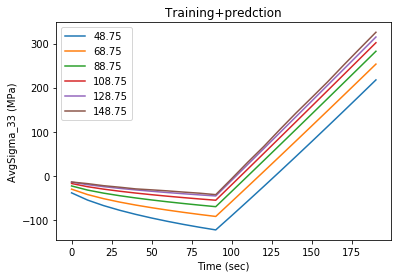

In [ ]:
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### It seems when loss goes below 0.1 then the corresponding model parameters cannot predict well the next sequence. The prediction at VE size = 148.75 seems similar to DNN.

#### Lets try to reduce loss to less than 0.05, and see what happens to prediction

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.05) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(20, 1)),
    tf.keras.layers.LSTM(32, activation='relu'),   
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
#Huber results fluctuating prediction, mae is not also stable, MSE is the best here
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[callbacks])

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 3s 684ms/sample - loss: 15567.5098
Epoch 2/1000
4/4 [==============================] - 0s 14ms/sample - loss: 16014.6699
Epoch 3/1000
4/4 [==============================] - 0s 13ms/sample - loss: 21238.1309
Epoch 4/1000
4/4 [==============================] - 0s 16ms/sample - loss: 13663.0264
Epoch 5/1000
4/4 [==============================] - 0s 13ms/sample - loss: 52684.7383
Epoch 6/1000
4/4 [==============================] - 0s 14ms/sample - loss: 28013.5879
Epoch 7/1000
4/4 [==============================] - 0s 17ms/sample - loss: 13788.3086
Epoch 8/1000
4/4 [==============================] - 0s 15ms/sample - loss: 18880.8633
Epoch 9/1000
4/4 [==============================] - 0s 16ms/sample - loss: 236949.5000
Epoch 10/1000
4/4 [==============================] - 0s 14ms/sample - loss: 271622.5625
Epoch 11/1000
4/4 [==============================] - 0s 14ms/sample - loss: 153793.3594
Epoch 12/1000
4/4 [==========

[[-13.637341 -19.431694 -23.654465 -27.414139 -30.739107 -33.895992
  -36.571457 -39.210846 -41.6724   -44.02177   -8.98549   27.542858
   63.43332   99.05971  135.4446   171.53325  206.77725  244.33969
  280.26065  316.45273 ]]


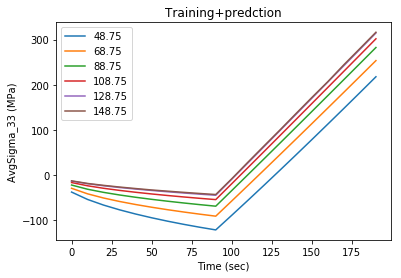

In [ ]:
prediction1x=Ytrain[3].reshape((1, Ytrain[3].shape[0], 1))
pred148_75=model.predict(prediction1x)
print(pred148_75)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### It did not go below 0.05, but stops at 0.3 approximately after max epoch specified. Surprisinly the prediciton seems wonderful.

#### Now check again the statement, i.e. loss around 0.3 the model is really effective?

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 2s 553ms/sample - loss: 24304.0195
Epoch 2/1000
4/4 [==============================] - 0s 19ms/sample - loss: 13870.5898
Epoch 3/1000
4/4 [==============================] - 0s 15ms/sample - loss: 1509953.0000
Epoch 4/1000
4/4 [==============================] - 0s 14ms/sample - loss: 165391.9375
Epoch 5/1000
4/4 [==============================] - 0s 13ms/sample - loss: 34006.7695
Epoch 6/1000
4/4 [==============================] - 0s 14ms/sample - loss: 30256.8047
Epoch 7/1000
4/4 [==============================] - 0s 15ms/sample - loss: 47943.8438
Epoch 8/1000
4/4 [==============================] - 0s 15ms/sample - loss: 34542.1953
Epoch 9/1000
4/4 [==============================] - 0s 15ms/sample - loss: 23994.2617
Epoch 10/1000
4/4 [==============================] - 0s 15ms/sample - loss: 14173.2725
Epoch 11/1000
4/4 [==============================] - 0s 15ms/sample - loss: 13187.1904
Epoch 12/1000
4/4 [==========

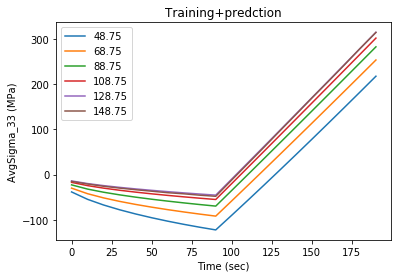

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.3) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(20, 1)),
    tf.keras.layers.LSTM(32, activation='relu'),   
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[callbacks])

prediction1x=Ytrain[3].reshape((1, Ytrain[3].shape[0], 1))
pred148_75=model.predict(prediction1x)
print(pred148_75)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### Lets check the next prediction i.e. at 168.75 whether it is meaningful 

[[-15.098755 -20.890152 -25.775473 -29.834185 -33.390842 -36.630394
  -39.93315  -42.33788  -45.342796 -47.792088 -11.669033  24.335419
   60.339645  96.81602  133.09592  169.6083   205.51889  241.91353
  278.98093  314.93774 ]]


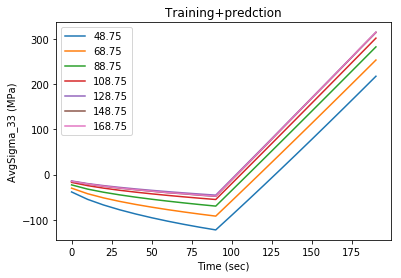

In [ ]:
prediction2x=pred148_75.reshape((pred148_75.shape[0], pred148_75.shape[1], 1))
pred168_75=model.predict(prediction2x)
print(pred168_75)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.plot(time, pred168_75[0],  label='168.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### So the prediction at 168.75 looks great. Now let's have a look at training losses.

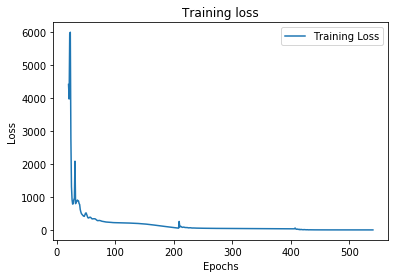

In [ ]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs[20:], loss[20:],  label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Now explore what happens when we increase another hidder layer (3rd) with the above LSTM network

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 4s 975ms/sample - loss: 15363.0254
Epoch 2/1000
4/4 [==============================] - 0s 23ms/sample - loss: 22785.8906
Epoch 3/1000
4/4 [==============================] - 0s 20ms/sample - loss: 20552.0020
Epoch 4/1000
4/4 [==============================] - 0s 24ms/sample - loss: 9177.4551
Epoch 5/1000
4/4 [==============================] - 0s 26ms/sample - loss: 36028.8633
Epoch 6/1000
4/4 [==============================] - 0s 26ms/sample - loss: 10766.1064
Epoch 7/1000
4/4 [==============================] - 0s 19ms/sample - loss: 9844.2646
Epoch 8/1000
4/4 [==============================] - 0s 19ms/sample - loss: 16760.1172
Epoch 9/1000
4/4 [==============================] - 0s 20ms/sample - loss: 10876.8164
Epoch 10/1000
4/4 [==============================] - 0s 20ms/sample - loss: 8832.9727
Epoch 11/1000
4/4 [==============================] - 0s 19ms/sample - loss: 7886.7012
Epoch 12/1000
4/4 [=================

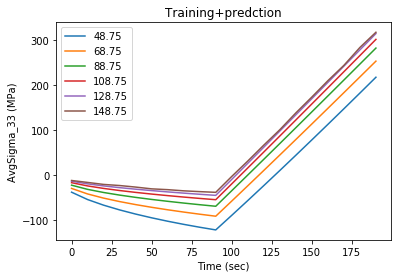

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.3) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(20, 1)),
    tf.keras.layers.LSTM(32, activation='relu',  return_sequences=True,),  
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[callbacks])

prediction1x=Ytrain[3].reshape((1, Ytrain[3].shape[0], 1))
pred148_75=model.predict(prediction1x)
print(pred148_75)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### It looks great as well. Please have a look at the below figure 

[[-11.744096 -15.644216 -20.105377 -22.025637 -25.522308 -29.732594
  -31.068161 -33.522232 -35.150097 -36.441647  -1.414384  32.18277
   67.02849  100.697235 138.15761  173.3043   209.0356   242.2294
  282.22607  315.48752 ]]


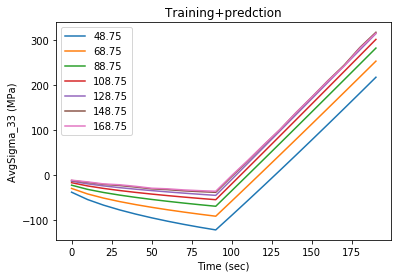

In [ ]:
prediction2x=pred148_75.reshape((pred148_75.shape[0], pred148_75.shape[1], 1))
pred168_75=model.predict(prediction2x)
print(pred168_75)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.plot(time, pred168_75[0],  label='168.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### The prediction at 168.75 looks great again for three hidden layers as well. Below are the training losses for three layer LSTM network

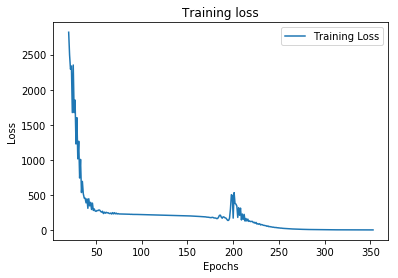

In [ ]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs[20:], loss[20:],  label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

============================================================
============================================================


#### Lets change the model architecture. Instead of one curve (1-to-1 architecture), now lets explore two curves as input and one curves as output (2-to-1 architecture). So there will be three sets of (X,Y) or 3 features.


In [ ]:
X = np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]]])
Y = np.array([series[2],series[3],series[4]])
print(X)
print(Y)

[[[-3.85728372e+01 -5.49696605e+01 -6.75108209e+01 -7.80635725e+01
   -8.73350760e+01 -9.56729234e+01 -1.03271046e+02 -1.10247634e+02
   -1.16681362e+02 -1.22629082e+02 -9.01058811e+01 -5.71779755e+01
   -2.38770753e+01  9.76832072e+00  4.37326010e+01  7.79922094e+01
    1.12525554e+02  1.47312661e+02  1.82335075e+02  2.17575669e+02]
  [-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.53442698e+02]]

 [[-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.5344

In [ ]:
X.shape

(3, 2, 20)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.1) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(2, 20)),
    tf.keras.layers.LSTM(32, activation='relu'),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(X, Y, epochs=1000, callbacks=[callbacks])

Train on 3 samples
Epoch 1/1000
3/3 [==============================] - 2s 828ms/sample - loss: 15960.6982
Epoch 2/1000
3/3 [==============================] - 0s 5ms/sample - loss: 14927.6406
Epoch 3/1000
3/3 [==============================] - 0s 5ms/sample - loss: 16068.6514
Epoch 4/1000
3/3 [==============================] - 0s 5ms/sample - loss: 11036.9805
Epoch 5/1000
3/3 [==============================] - 0s 4ms/sample - loss: 12646.5508
Epoch 6/1000
3/3 [==============================] - 0s 4ms/sample - loss: 7461.3320
Epoch 7/1000
3/3 [==============================] - 0s 4ms/sample - loss: 6098.8569
Epoch 8/1000
3/3 [==============================] - 0s 4ms/sample - loss: 4864.4897
Epoch 9/1000
3/3 [==============================] - 0s 4ms/sample - loss: 2873.3899
Epoch 10/1000
3/3 [==============================] - 0s 4ms/sample - loss: 1480.2861
Epoch 11/1000
3/3 [==============================] - 0s 4ms/sample - loss: 2299.6731
Epoch 12/1000
3/3 [=============================

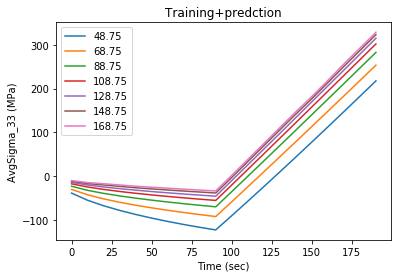

In [ ]:
prediction1=np.array([series[3],series[4]])
prediction1= prediction1.reshape((1,prediction1.shape[0], prediction1.shape[1]))
pred148_75=model.predict(prediction1)

prediction2=np.array([series[4],pred148_75[0]])
prediction2= prediction2.reshape((1,prediction2.shape[0], prediction2.shape[1]))
pred168_75=model.predict(prediction2)

time=range(0,200,10)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.plot(time, pred168_75[0],  label='168.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### it seems for loss at 0.1 the predictions are very impressive for 2-to-1 architecture, whereas in 1-to-1 architecture loss is 0.3 is preferable 

==============================================================================================

#### Lets explore 3-to-1 architecture

In [ ]:
X1 = np.array([[series[0],series[1],series[2]],[series[1],series[2],series[3]]])
Y1 = np.array([series[3],series[4]])
print(X1)
print(Y1)

[[[-3.85728372e+01 -5.49696605e+01 -6.75108209e+01 -7.80635725e+01
   -8.73350760e+01 -9.56729234e+01 -1.03271046e+02 -1.10247634e+02
   -1.16681362e+02 -1.22629082e+02 -9.01058811e+01 -5.71779755e+01
   -2.38770753e+01  9.76832072e+00  4.37326010e+01  7.79922094e+01
    1.12525554e+02  1.47312661e+02  1.82335075e+02  2.17575669e+02]
  [-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.53442698e+02]
  [-2.29372278e+01 -3.22702133e+01 -3.92435865e+01 -4.50476037e+01
   -5.01266838e+01 -5.47012760e+01 -5.88988089e+01 -6.28006302e+01
   -6.64623979e+01 -6.99241136e+01 -3.51816207e+01 -2.91889294e-01
    3.47271115e+01  6.98609524e+01  1.05098072e+02  1.40428913e+02
    1.75845570e+02  2.11341529e+02  2.46911186e+02  2.825499

In [ ]:
X1.shape

(2, 3, 20)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.1) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(3, 20)),
    tf.keras.layers.LSTM(32, activation='relu'),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(X1, Y1, epochs=1000, callbacks=[callbacks])

Train on 2 samples
Epoch 1/1000
2/2 [==============================] - 2s 1s/sample - loss: 16657.1426
Epoch 2/1000
2/2 [==============================] - 0s 9ms/sample - loss: 15746.6494
Epoch 3/1000
2/2 [==============================] - 0s 7ms/sample - loss: 12936.3574
Epoch 4/1000
2/2 [==============================] - 0s 7ms/sample - loss: 11903.8477
Epoch 5/1000
2/2 [==============================] - 0s 9ms/sample - loss: 6957.7900
Epoch 6/1000
2/2 [==============================] - 0s 7ms/sample - loss: 5235.8604
Epoch 7/1000
2/2 [==============================] - 0s 6ms/sample - loss: 3177.9724
Epoch 8/1000
2/2 [==============================] - 0s 7ms/sample - loss: 1541.6279
Epoch 9/1000
2/2 [==============================] - 0s 7ms/sample - loss: 574.3966
Epoch 10/1000
2/2 [==============================] - 0s 7ms/sample - loss: 1800.4912
Epoch 11/1000
2/2 [==============================] - 0s 8ms/sample - loss: 1271.0325
Epoch 12/1000
2/2 [==============================] - 

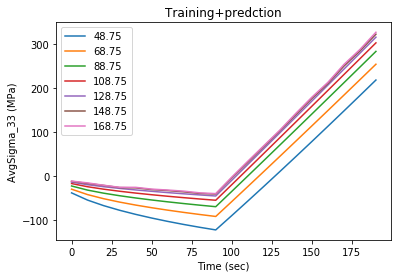

In [ ]:
prediction1=np.array([series[2],series[3],series[4]])
prediction1= prediction1.reshape((1,prediction1.shape[0], prediction1.shape[1]))
pred148_75=model.predict(prediction1)

prediction2=np.array([series[3],series[4],pred148_75[0]])
prediction2= prediction2.reshape((1,prediction2.shape[0], prediction2.shape[1]))
pred168_75=model.predict(prediction2)

time=range(0,200,10)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
plt.plot(time, pred168_75[0],  label='168.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### Remarks: 
it appears that 2-to-1 LSTM architecture is far better, stable  and it also has faster convergence than that of 1-to-1 and 3-to-1 architectures.

#### Summary: 
The RVE size $d=168.75\times 168.75\times 168.75 \mu m^3$ can be considered the proper size in this case and the predicted sequence at this size is not biased. Moreover if we observe carefully the predicted results at  168.75 and 148.75 size have very little or negligible variance.